In [19]:
import os
import glob
import json
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm
from ultralytics import YOLO

INPUT_ROOT = 'bdd10k' 
YOLO_DIR = 'datasets/bdd_yolo'
UNET_DIR = 'datasets/bdd_unet'
DATASET_DIR = YOLO_DIR

IMG_SIZE = (640, 360) 
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

CLASS_MAP = {'car': 0, 'pedestrian': 1, 'truck': 2} 

LIMIT_VAL = 400 

LIMIT_TRAIN_TOTAL = 2800 
TEST_SPLIT_SIZE   = 400 

print(f"Configuration Set. Using Device: {DEVICE}")
print(f"Data will be saved to: {os.path.abspath(YOLO_DIR)}")

Configuration Set. Using Device: cuda
Data will be saved to: c:\Users\Filip\Desktop\Studia\sem5\CV\project3\datasets\bdd_yolo


In [20]:
def setup_dirs():
    for split in ['train', 'val', 'test']:
        for d in [YOLO_DIR, UNET_DIR]:
            os.makedirs(f"{d}/images/{split}", exist_ok=True)
            os.makedirs(f"{d}/labels/{split}", exist_ok=True) 
            os.makedirs(f"{d}/masks/{split}", exist_ok=True)

def process_single_image(img_path, ann_folder, split_name):
    """Helper function to process one image and save it to the specific split."""
    filename = os.path.basename(img_path)
    file_root = os.path.splitext(filename)[0]
    
    json_path = os.path.join(ann_folder, file_root + ".json")
    if not os.path.exists(json_path):
        candidates = glob.glob(os.path.join(ann_folder, f"*{file_root}*.json"))
        if candidates: json_path = candidates[0]
        else: return False

    img = cv2.imread(img_path)
    if img is None: return False
    h, w = img.shape[:2]
    
    with open(json_path, 'r') as f:
        data = json.load(f)
    
    img_resized = cv2.resize(img, IMG_SIZE)
    mask = np.zeros((h, w), dtype=np.uint8)
    yolo_lines = []
    has_valid_obj = False
    
    objects = data.get('objects', [])
    for obj in objects:
        class_title = obj.get('classTitle')
        if class_title not in CLASS_MAP: continue
        
        if obj.get('geometryType') == 'rectangle': continue
        
        points_ext = obj.get('points', {}).get('exterior', [])
        if not points_ext: continue

        poly_points = np.array(points_ext, dtype=np.int32)
        cls_id = CLASS_MAP[class_title]

        cv2.fillPoly(mask, [poly_points], cls_id + 1)
        
        norm_pts = []
        for p in poly_points:
            px = min(max(p[0] / w, 0.0), 1.0)
            py = min(max(p[1] / h, 0.0), 1.0)
            norm_pts.extend([px, py])
        
        yolo_str = f"{cls_id} " + " ".join([f"{x:.6f}" for x in norm_pts])
        yolo_lines.append(yolo_str)
        has_valid_obj = True

    if has_valid_obj:
        cv2.imwrite(f"{YOLO_DIR}/images/{split_name}/{filename}", img_resized)
        cv2.imwrite(f"{UNET_DIR}/images/{split_name}/{filename}", img_resized)
        
        mask_resized = cv2.resize(mask, IMG_SIZE, interpolation=cv2.INTER_NEAREST)
        cv2.imwrite(f"{UNET_DIR}/masks/{split_name}/{file_root}.png", mask_resized)
        
        with open(f"{YOLO_DIR}/labels/{split_name}/{file_root}.txt", 'w') as f:
            f.write("\n".join(yolo_lines))
        return True
    
    return False

def process_new_dataset():
    abs_path = os.path.abspath(INPUT_ROOT)
    print(f"Looking for dataset at: {abs_path}")
    
    if not os.path.exists(INPUT_ROOT):
        print("ERROR: Input folder not found.")
        return

    setup_dirs()
    
    img_folder_val = os.path.join(INPUT_ROOT, 'val', 'img')
    ann_folder_val = os.path.join(INPUT_ROOT, 'val', 'ann')
    
    if os.path.exists(img_folder_val):
        print("Processing Validation Set...")
        files = glob.glob(os.path.join(img_folder_val, "*.jpg"))
        count = 0
        for f in tqdm(files):
            if count >= LIMIT_VAL: break
            if process_single_image(f, ann_folder_val, 'val'):
                count += 1
    else:
        print(f"'val' folder not found at {img_folder_val}")

    img_folder_train = os.path.join(INPUT_ROOT, 'train', 'img')
    ann_folder_train = os.path.join(INPUT_ROOT, 'train', 'ann')
    
    if os.path.exists(img_folder_train):
        print("Processing Train Set (splitting into Train/Test)...")
        files = glob.glob(os.path.join(img_folder_train, "*.jpg"))
        
        train_count = 0
        test_count = 0
        total_processed = 0
        
        for f in tqdm(files):
            if total_processed >= LIMIT_TRAIN_TOTAL: break
            
            if test_count < TEST_SPLIT_SIZE:
                target_split = 'test'
            else:
                target_split = 'train'
            
            if process_single_image(f, ann_folder_train, target_split):
                if target_split == 'test': test_count += 1
                else: train_count += 1
                total_processed += 1
                
        print(f" - Created Test Set: {test_count} images")
        print(f" - Created Train Set: {train_count} images")
    else:
        print(f"'train' folder not found at {img_folder_train}")

    print("Dataset processing complete.")

process_new_dataset()

Looking for dataset at: c:\Users\Filip\Desktop\Studia\sem5\CV\project3\bdd10k
Processing Validation Set...


  0%|          | 0/1000 [00:00<?, ?it/s]

Processing Train Set (splitting into Train/Test)...


  0%|          | 0/7000 [00:00<?, ?it/s]

 - Created Test Set: 400 images
 - Created Train Set: 2400 images
Dataset processing complete.


In [21]:
DATASET_DIR = 'datasets/bdd_yolo' 

import os
if os.path.exists(f"{DATASET_DIR}/images/train"):
    print(f"Path found: {DATASET_DIR}/images/train")
else:
    print(f"Path not found. Check if 'datasets/bdd_yolo' exists.")

Path found: datasets/bdd_yolo/images/train


In [22]:
class BDDInstanceDataset(Dataset):
    def __init__(self, split, transform=None):
        self.split = split
        self.img_dir = f"{DATASET_DIR}/images/{split}"
        self.label_dir = f"{DATASET_DIR}/labels/{split}"
        self.img_names = [f for f in os.listdir(self.img_dir) if f.endswith('.jpg')]
        self.transform = transform

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        img_path = os.path.join(self.img_dir, img_name)
        label_path = os.path.join(self.label_dir, img_name.replace('.jpg', '.txt'))
        
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]
        
        boxes = []
        labels = []
        masks = []
        
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                lines = f.readlines()
            
            for line in lines:
                parts = list(map(float, line.strip().split()))
                cls_id = int(parts[0])
                coords = parts[1:]
                
                poly_pts = []
                for i in range(0, len(coords), 2):
                    px = min(max(int(coords[i] * w), 0), w)
                    py = min(max(int(coords[i+1] * h), 0), h)
                    poly_pts.append([px, py])
                
                poly_pts = np.array(poly_pts, dtype=np.int32)
                if len(poly_pts) < 3: continue

                mask = np.zeros((h, w), dtype=np.uint8)
                cv2.fillPoly(mask, [poly_pts], 1)
                masks.append(mask)
                
                x_min, y_min = np.min(poly_pts, axis=0)
                x_max, y_max = np.max(poly_pts, axis=0)
                
                if x_max > x_min and y_max > y_min:
                    boxes.append([x_min, y_min, x_max, y_max])
                    labels.append(cls_id + 1)

        img_tensor = transforms.ToTensor()(img)

        if len(boxes) > 0:
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)
            masks = torch.as_tensor(np.array(masks), dtype=torch.uint8)
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
            iscrowd = torch.zeros((len(boxes),), dtype=torch.int64)
            
            target = {
                "boxes": boxes, "labels": labels, "masks": masks, 
                "image_id": torch.tensor([idx]), "area": area, "iscrowd": iscrowd
            }
        else:
            target = {
                "boxes": torch.zeros((0, 4), dtype=torch.float32),
                "labels": torch.zeros((0,), dtype=torch.int64),
                "masks": torch.zeros((0, h, w), dtype=torch.uint8),
                "image_id": torch.tensor([idx]),
                "area": torch.zeros((0,), dtype=torch.float32),
                "iscrowd": torch.zeros((0,), dtype=torch.int64)
            }

        return img_tensor, target

def collate_fn(batch):
    return tuple(zip(*batch))

In [23]:
def get_model_instance_segmentation(num_classes):
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights='DEFAULT')
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

    return model

def train_mask_rcnn():
    num_classes = len(CLASS_MAP) + 1 
    model = get_model_instance_segmentation(num_classes).to(DEVICE)
    
    dataset_train = BDDInstanceDataset('train')
    data_loader = DataLoader(dataset_train, batch_size=2, shuffle=True, collate_fn=collate_fn)
    
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
    
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

    print("Starting Mask R-CNN Training...")
    writer = SummaryWriter('runs/mask_rcnn')
    model.train()
    
    num_epochs = 15
    for epoch in range(num_epochs):
        epoch_loss = 0
        pbar = tqdm(data_loader, desc=f"Epoch {epoch+1}")
        
        for images, targets in pbar:
            images = list(image.to(DEVICE) for image in images)
            targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
            
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
            
            epoch_loss += losses.item()
            pbar.set_postfix({'Loss': losses.item()})
            
        lr_scheduler.step()
        avg_loss = epoch_loss / len(data_loader)
        writer.add_scalar('Loss/train', avg_loss, epoch)
        print(f"Epoch {epoch+1} Average Loss: {avg_loss:.4f}")
        
    torch.save(model.state_dict(), "mask_rcnn_bdd.pth")
    print("Mask R-CNN Training Complete.")

train_mask_rcnn()

Starting Mask R-CNN Training...


Epoch 1:   0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 1 Average Loss: 1.2188


Epoch 2:   0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 2 Average Loss: 1.0642


Epoch 3:   0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 3 Average Loss: 0.9895


Epoch 4:   0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 4 Average Loss: 0.8525


Epoch 5:   0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 5 Average Loss: 0.8227


Epoch 6:   0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 6 Average Loss: 0.8018


Epoch 7:   0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 7 Average Loss: 0.7744


Epoch 8:   0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 8 Average Loss: 0.7723


Epoch 9:   0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 9 Average Loss: 0.7704


Epoch 10:   0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 10 Average Loss: 0.7678


Epoch 11:   0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 11 Average Loss: 0.7679


Epoch 12:   0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 12 Average Loss: 0.7658


Epoch 13:   0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 13 Average Loss: 0.7669


Epoch 14:   0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 14 Average Loss: 0.7670


Epoch 15:   0%|          | 0/1200 [00:00<?, ?it/s]

Epoch 15 Average Loss: 0.7666
Mask R-CNN Training Complete.


In [24]:
yaml_content = f"""
path: {os.path.abspath(DATASET_DIR)}
train: images/train
val: images/val
test: images/test
names:
  0: car
  1: pedestrian
  2: truck
"""
with open("bdd_instance.yaml", "w") as f:
    f.write(yaml_content)

def train_yolo_instance():
    model = YOLO('yolov8n-seg.pt') 
    
    print("Starting YOLOv8-Seg Training...")
    results = model.train(
        data='bdd_instance.yaml',
        epochs=10,
        imgsz=640,
        batch=8,
        project='Project3_Report',
        name='yolo_instance_run',
        plots=True
    )
    print("YOLO Training Complete.")

train_yolo_instance()

Starting YOLOv8-Seg Training...
New https://pypi.org/project/ultralytics/8.4.8 available  Update with 'pip install -U ultralytics'
Ultralytics 8.4.7  Python-3.12.4 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4070, 12282MiB)
engine\trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=bdd_instance.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, 

c:\Users\Filip\anaconda3\Lib\site-packages\ultralytics\nn\modules\block.py:1324: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:217.)
  attn = (q.transpose(-2, -1) @ k) * self.scale
c:\Users\Filip\anaconda3\Lib\site-packages\ultralytics\nn\modules\block.py:1326: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(tru

train: Scanning C:\Users\Filip\Desktop\Studia\sem5\CV\project3\datasets\bdd_yolo\labels\train.cache... 2400 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 2400/2400  0.0s
val: Fast image access  (ping: 0.10.0 ms, read: 7.91.1 MB/s, size: 78.3 KB)
val: Scanning C:\Users\Filip\Desktop\Studia\sem5\CV\project3\datasets\bdd_yolo\labels\val.cache... 400 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 400/400  0.0s
Plotting labels to C:\Users\Filip\runs\segment\Project3_Report\yolo_instance_run7\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: MuSGD(lr=0.001429, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to C:\Users\Filip\runs\segment\Project3_Report\yolo_instance_run7
Starting training for 10 epochs...
Closing dataloader mosaic


c:\Users\Filip\anaconda3\Lib\site-packages\ultralytics\utils\loss.py:384: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
c:\Users\Filip\anaconda3\Lib\site-packages\torch\functional.py:407: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::s

       1/10      3.55G      1.667      3.505      3.903      1.185          0         82        640: 2% ──────────── 6/300 6.8it/s 1.1s<43.2s

c:\Users\Filip\anaconda3\Lib\site-packages\ultralytics\optim\muon.py:51: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:217.)
  A = X @ X.T
c:\Users\Filip\anaconda3\Lib\site-packages\ultralytics\optim\muon.py:52: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic becau

       1/10      3.55G      1.527      2.883      3.081      1.052          0         94        640: 100% ━━━━━━━━━━━━ 300/300 9.4it/s 31.8ss<0.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 4% ──────────── 1/25 2.5it/s 0.1s<9.8s

c:\Users\Filip\anaconda3\Lib\site-packages\ultralytics\utils\ops.py:496: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:217.)
  masks = (masks_in @ protos.float().view(c, -1)).view(-1, mh, mw)  # NHW
c:\Users\Filip\anaconda3\Lib\site-packages\ultralytics\utils\metrics.py:163: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministic

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 25/25 8.7it/s 2.9s0.1s
                   all        400       4645      0.645      0.137       0.16      0.102      0.642      0.131      0.149     0.0838

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss   sem_loss  Instances       Size
       2/10      3.55G      1.547      2.871      1.961     0.9305          0        117        640: 0% ──────────── 0/300  0.1s

c:\Users\Filip\anaconda3\Lib\site-packages\ultralytics\utils\loss.py:384: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
c:\Users\Filip\anaconda3\Lib\site-packages\torch\functional.py:407: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::s

       2/10      3.55G      1.374      2.589       1.59      1.002          0        108        640: 100% ━━━━━━━━━━━━ 300/300 11.7it/s 25.6s0.2ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 8% ╸─────────── 2/25 4.4it/s 0.2s<5.3s

c:\Users\Filip\anaconda3\Lib\site-packages\ultralytics\utils\ops.py:496: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:217.)
  masks = (masks_in @ protos.float().view(c, -1)).view(-1, mh, mw)  # NHW
c:\Users\Filip\anaconda3\Lib\site-packages\ultralytics\utils\metrics.py:163: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministic

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 25/25 8.7it/s 2.9s0.1s
                   all        400       4645      0.425       0.32      0.307      0.188      0.403      0.308      0.294      0.157

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss   sem_loss  Instances       Size
       3/10      3.55G      1.161      2.385      1.136     0.9407          0        117        640: 0% ──────────── 1/300 1.9it/s 0.2s<2:37

c:\Users\Filip\anaconda3\Lib\site-packages\ultralytics\utils\loss.py:384: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
c:\Users\Filip\anaconda3\Lib\site-packages\torch\functional.py:407: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::s

       3/10      3.55G      1.268      2.503      1.301     0.9568          0        115        640: 1% ──────────── 4/300 6.1it/s 0.4s<48.5s

c:\Users\Filip\anaconda3\Lib\site-packages\ultralytics\optim\muon.py:51: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:217.)
  A = X @ X.T
c:\Users\Filip\anaconda3\Lib\site-packages\ultralytics\optim\muon.py:52: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic becau

       3/10      3.55G      1.295      2.484      1.303     0.9875          0         60        640: 100% ━━━━━━━━━━━━ 300/300 12.8it/s 23.5s0.2ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 8% ╸─────────── 2/25 4.5it/s 0.2s<5.1s

c:\Users\Filip\anaconda3\Lib\site-packages\ultralytics\utils\ops.py:496: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:217.)
  masks = (masks_in @ protos.float().view(c, -1)).view(-1, mh, mw)  # NHW
c:\Users\Filip\anaconda3\Lib\site-packages\ultralytics\utils\metrics.py:163: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministic

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 25/25 8.4it/s 3.0s0.1s
                   all        400       4645       0.47      0.329      0.344      0.214      0.453      0.312      0.321      0.178

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss   sem_loss  Instances       Size
       4/10      3.55G      1.137      2.175      1.252     0.9934          0         66        640: 0% ──────────── 1/300 2.0it/s 0.1s<2:29

c:\Users\Filip\anaconda3\Lib\site-packages\ultralytics\utils\loss.py:384: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
c:\Users\Filip\anaconda3\Lib\site-packages\torch\functional.py:407: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::s

       4/10      3.55G      1.216      2.417      1.213     0.9894          0         96        640: 1% ──────────── 4/300 5.7it/s 0.5s<51.7s

c:\Users\Filip\anaconda3\Lib\site-packages\ultralytics\optim\muon.py:51: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:217.)
  A = X @ X.T
c:\Users\Filip\anaconda3\Lib\site-packages\ultralytics\optim\muon.py:52: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic becau

       4/10      3.55G      1.264       2.43      1.226     0.9836          0         94        640: 100% ━━━━━━━━━━━━ 300/300 12.7it/s 23.6s0.1ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 8% ╸─────────── 2/25 4.6it/s 0.2s<4.9s

c:\Users\Filip\anaconda3\Lib\site-packages\ultralytics\utils\ops.py:496: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:217.)
  masks = (masks_in @ protos.float().view(c, -1)).view(-1, mh, mw)  # NHW
c:\Users\Filip\anaconda3\Lib\site-packages\ultralytics\utils\metrics.py:163: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministic

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 25/25 9.0it/s 2.8s0.1s
                   all        400       4645      0.542      0.349      0.376      0.236      0.524      0.333      0.359      0.198

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss   sem_loss  Instances       Size
       5/10      3.55G       1.21      2.487      1.041     0.9397          0        114        640: 0% ──────────── 0/300  0.1s

c:\Users\Filip\anaconda3\Lib\site-packages\ultralytics\utils\loss.py:384: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
c:\Users\Filip\anaconda3\Lib\site-packages\torch\functional.py:407: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::s

       5/10      3.55G      1.239      2.385      1.164     0.9739          0        109        640: 100% ━━━━━━━━━━━━ 300/300 13.2it/s 22.7s0.1ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 8% ╸─────────── 2/25 4.7it/s 0.2s<4.9s

c:\Users\Filip\anaconda3\Lib\site-packages\ultralytics\utils\ops.py:496: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:217.)
  masks = (masks_in @ protos.float().view(c, -1)).view(-1, mh, mw)  # NHW
c:\Users\Filip\anaconda3\Lib\site-packages\ultralytics\utils\metrics.py:163: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministic

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 25/25 9.1it/s 2.8s0.1s
                   all        400       4645      0.545      0.371      0.387      0.244      0.533      0.352      0.367      0.204

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss   sem_loss  Instances       Size
       6/10      3.55G      1.107      2.138     0.9933     0.9477          0         98        640: 0% ──────────── 1/300 2.1it/s 0.1s<2:19

c:\Users\Filip\anaconda3\Lib\site-packages\ultralytics\utils\loss.py:384: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
c:\Users\Filip\anaconda3\Lib\site-packages\torch\functional.py:407: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::s

       6/10      3.55G      1.237      2.265      1.101     0.9616          0         76        640: 1% ──────────── 4/300 6.3it/s 0.4s<47.0s

c:\Users\Filip\anaconda3\Lib\site-packages\ultralytics\optim\muon.py:51: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:217.)
  A = X @ X.T
c:\Users\Filip\anaconda3\Lib\site-packages\ultralytics\optim\muon.py:52: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic becau

       6/10      3.55G      1.217      2.339       1.12     0.9675          0        123        640: 100% ━━━━━━━━━━━━ 300/300 13.3it/s 22.6s0.1ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 8% ╸─────────── 2/25 4.7it/s 0.2s<4.9s

c:\Users\Filip\anaconda3\Lib\site-packages\ultralytics\utils\ops.py:496: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:217.)
  masks = (masks_in @ protos.float().view(c, -1)).view(-1, mh, mw)  # NHW
c:\Users\Filip\anaconda3\Lib\site-packages\ultralytics\utils\metrics.py:163: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministic

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 25/25 9.1it/s 2.7s0.1s
                   all        400       4645      0.533       0.38      0.393      0.251      0.487      0.374      0.377       0.21

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss   sem_loss  Instances       Size
       7/10      3.55G      1.386       2.52      1.185       1.07          0        114        640: 0% ──────────── 0/300  0.1s

c:\Users\Filip\anaconda3\Lib\site-packages\ultralytics\utils\loss.py:384: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
c:\Users\Filip\anaconda3\Lib\site-packages\torch\functional.py:407: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::s

       7/10      3.55G       1.21      2.328      1.105     0.9647          0        121        640: 100% ━━━━━━━━━━━━ 300/300 13.2it/s 22.7s0.1ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 8% ╸─────────── 2/25 4.7it/s 0.2s<4.9s

c:\Users\Filip\anaconda3\Lib\site-packages\ultralytics\utils\ops.py:496: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:217.)
  masks = (masks_in @ protos.float().view(c, -1)).view(-1, mh, mw)  # NHW
c:\Users\Filip\anaconda3\Lib\site-packages\ultralytics\utils\metrics.py:163: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministic

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 25/25 9.1it/s 2.7s0.1s
                   all        400       4645      0.512      0.403      0.404      0.254      0.483      0.379      0.381       0.21

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss   sem_loss  Instances       Size
       8/10      3.55G      1.323      2.713      1.241      1.024          0         79        640: 0% ──────────── 1/300 2.0it/s 0.1s<2:29

c:\Users\Filip\anaconda3\Lib\site-packages\ultralytics\utils\loss.py:384: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
c:\Users\Filip\anaconda3\Lib\site-packages\torch\functional.py:407: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::s

       8/10      3.55G      1.231      2.641      1.113     0.9726          0         92        640: 1% ──────────── 4/300 6.5it/s 0.4s<45.8s

c:\Users\Filip\anaconda3\Lib\site-packages\ultralytics\optim\muon.py:51: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:217.)
  A = X @ X.T
c:\Users\Filip\anaconda3\Lib\site-packages\ultralytics\optim\muon.py:52: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic becau

       8/10      3.55G      1.193      2.298      1.069     0.9614          0         75        640: 100% ━━━━━━━━━━━━ 300/300 13.2it/s 22.7s0.1ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 8% ╸─────────── 2/25 4.8it/s 0.2s<4.8s

c:\Users\Filip\anaconda3\Lib\site-packages\ultralytics\utils\ops.py:496: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:217.)
  masks = (masks_in @ protos.float().view(c, -1)).view(-1, mh, mw)  # NHW
c:\Users\Filip\anaconda3\Lib\site-packages\ultralytics\utils\metrics.py:163: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministic

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 25/25 8.9it/s 2.8s0.1s
                   all        400       4645      0.533      0.388      0.407       0.26      0.509       0.37      0.387      0.217

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss   sem_loss  Instances       Size
       9/10      3.55G     0.9996      2.334     0.8927      0.923          0        105        640: 0% ──────────── 0/300  0.1s

c:\Users\Filip\anaconda3\Lib\site-packages\ultralytics\utils\loss.py:384: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
c:\Users\Filip\anaconda3\Lib\site-packages\torch\functional.py:407: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::s

       9/10      3.55G      1.177       2.27      1.049     0.9551          0        100        640: 100% ━━━━━━━━━━━━ 300/300 13.2it/s 22.7s0.1ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 8% ╸─────────── 2/25 4.7it/s 0.2s<4.9s

c:\Users\Filip\anaconda3\Lib\site-packages\ultralytics\utils\ops.py:496: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:217.)
  masks = (masks_in @ protos.float().view(c, -1)).view(-1, mh, mw)  # NHW
c:\Users\Filip\anaconda3\Lib\site-packages\ultralytics\utils\metrics.py:163: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministic

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 25/25 9.1it/s 2.7s0.1s
                   all        400       4645       0.54      0.398      0.414      0.266      0.543      0.363      0.391       0.22

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss   sem_loss  Instances       Size
      10/10      3.55G      1.188       2.36      1.013     0.9122          0         93        640: 0% ──────────── 1/300 2.1it/s 0.1s<2:22

c:\Users\Filip\anaconda3\Lib\site-packages\ultralytics\utils\loss.py:384: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:217.)
  pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul(self.proj.type(pred_dist.dtype))
c:\Users\Filip\anaconda3\Lib\site-packages\torch\functional.py:407: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::s

      10/10      3.55G      1.234      2.501      1.101     0.9468          0         57        640: 1% ──────────── 4/300 6.1it/s 0.4s<48.3s

c:\Users\Filip\anaconda3\Lib\site-packages\ultralytics\optim\muon.py:51: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:217.)
  A = X @ X.T
c:\Users\Filip\anaconda3\Lib\site-packages\ultralytics\optim\muon.py:52: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic becau

      10/10      3.55G       1.17      2.257      1.035     0.9527          0        118        640: 100% ━━━━━━━━━━━━ 300/300 13.3it/s 22.6s0.1ss
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 8% ╸─────────── 2/25 4.2it/s 0.2s<5.5s

c:\Users\Filip\anaconda3\Lib\site-packages\ultralytics\utils\ops.py:496: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\Context.cpp:217.)
  masks = (masks_in @ protos.float().view(c, -1)).view(-1, mh, mw)  # NHW
c:\Users\Filip\anaconda3\Lib\site-packages\ultralytics\utils\metrics.py:163: UserWarning: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministic

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 25/25 9.1it/s 2.7s0.1s
                   all        400       4645       0.56      0.396      0.413      0.265       0.54      0.379      0.395      0.223

10 epochs completed in 0.079 hours.
Optimizer stripped from C:\Users\Filip\runs\segment\Project3_Report\yolo_instance_run7\weights\last.pt, 6.8MB
Optimizer stripped from C:\Users\Filip\runs\segment\Project3_Report\yolo_instance_run7\weights\best.pt, 6.8MB

Validating C:\Users\Filip\runs\segment\Project3_Report\yolo_instance_run7\weights\best.pt...
Ultralytics 8.4.7  Python-3.12.4 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 4070, 12282MiB)
YOLOv8n-seg summary (fused): 86 layers, 3,258,649 parameters, 0 gradients, 11.3 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 25/25 7.

In [34]:
%matplotlib inline
import os
import random
import matplotlib.pyplot as plt
import torch
import numpy as np
import cv2
from ultralytics import YOLO
import glob

DATASET_DIR = 'datasets/bdd_yolo' 

class BDDInstanceDataset(torch.utils.data.Dataset):
    def __init__(self, split, transform=None):
        self.split = split
        self.img_dir = f"{DATASET_DIR}/images/{split}"
        self.label_dir = f"{DATASET_DIR}/labels/{split}"
        
        if os.path.exists(self.img_dir):
            self.img_names = [f for f in os.listdir(self.img_dir) if f.endswith('.jpg')]
        else:
            self.img_names = []
            print(f"Warning: Directory not found: {self.img_dir}")

        self.transform = transform

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        img_path = os.path.join(self.img_dir, img_name)
        
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_tensor = transforms.ToTensor()(img)
        
        return img_tensor, None

def visualize_feature_maps():
    dataset = BDDInstanceDataset('val')
    
    if len(dataset) == 0:
        print(f"Error: No images found in {DATASET_DIR}/images/val")
        return

    model = get_model_instance_segmentation(len(CLASS_MAP)+1).to(DEVICE)
    if os.path.exists("mask_rcnn_bdd.pth"):
        model.load_state_dict(torch.load("mask_rcnn_bdd.pth"))
    model.eval()
    
    img, _ = dataset[0]
    
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output
        return hook

    model.backbone.body.layer1.register_forward_hook(get_activation('layer1'))
    
    with torch.no_grad():
        model([img.to(DEVICE)])
        
    if 'layer1' in activation:
        act = activation['layer1'].cpu().numpy()[0]
        
        fig, axes = plt.subplots(2, 4, figsize=(15, 8))
        fig.suptitle('Explainability: ResNet Backbone Layer 1 Feature Maps', fontsize=16)
        
        for i in range(8):
            row = i // 4
            col = i % 4
            if i < len(act):
                axes[row, col].imshow(act[i], cmap='viridis')
                axes[row, col].axis('off')
                axes[row, col].set_title(f'Filter {i}')
        
        plt.tight_layout()
        plt.show()
    else:
        print("Could not extract features.")

Loading YOLO from: C:\Users\Filip\runs/segment/Project3_Report\yolo_instance_run7\weights\best.pt

image 1/1 c:\Users\Filip\Desktop\Studia\sem5\CV\project3\datasets\bdd_yolo\images\val\8e7260f9-a3162bc8.jpg: 384x640 3 cars, 6.4ms
Speed: 0.5ms preprocess, 6.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


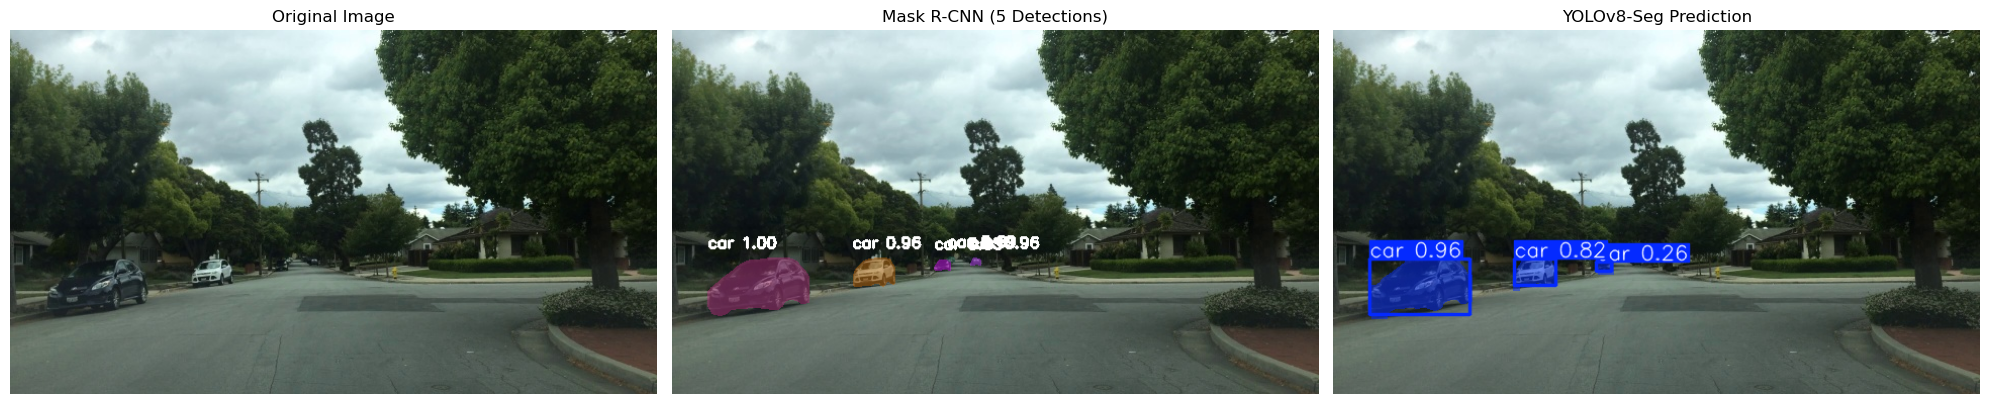

Loading YOLO from: C:\Users\Filip\runs/segment/Project3_Report\yolo_instance_run7\weights\best.pt

image 1/1 c:\Users\Filip\Desktop\Studia\sem5\CV\project3\datasets\bdd_yolo\images\val\82d184d4-00000000.jpg: 384x640 11 cars, 4.5ms
Speed: 0.7ms preprocess, 4.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


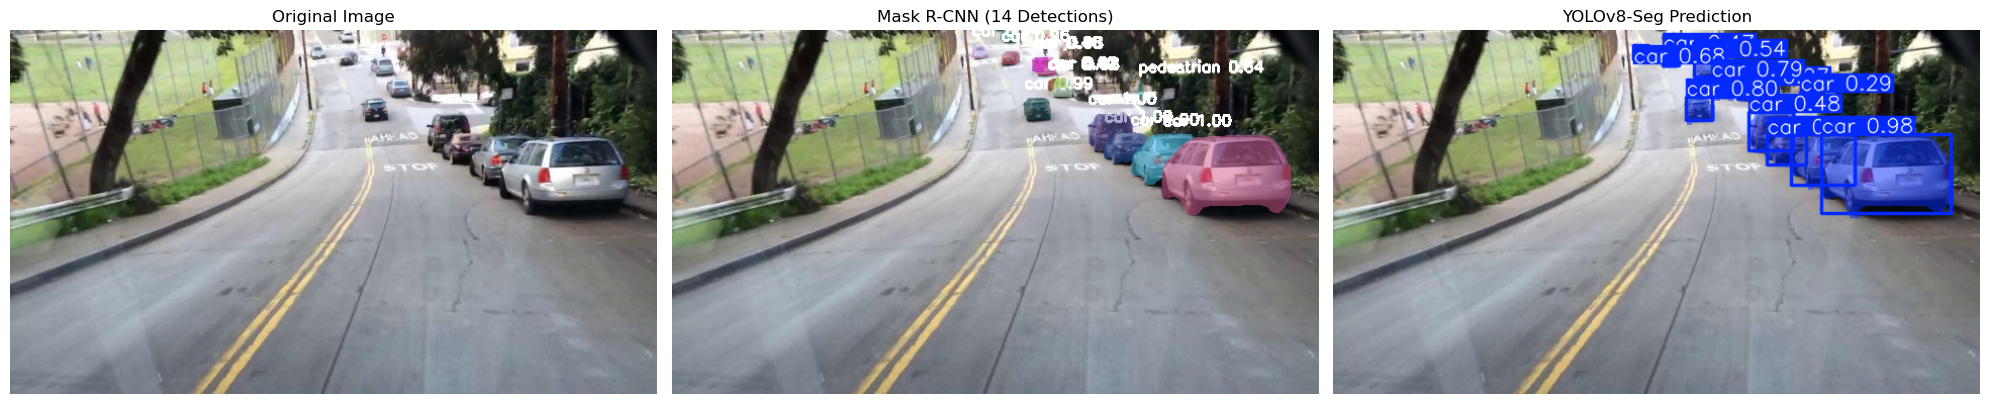

Loading YOLO from: C:\Users\Filip\runs/segment/Project3_Report\yolo_instance_run7\weights\best.pt

image 1/1 c:\Users\Filip\Desktop\Studia\sem5\CV\project3\datasets\bdd_yolo\images\val\8c9fffcc-b00aada0.jpg: 384x640 8 cars, 5.7ms
Speed: 0.5ms preprocess, 5.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


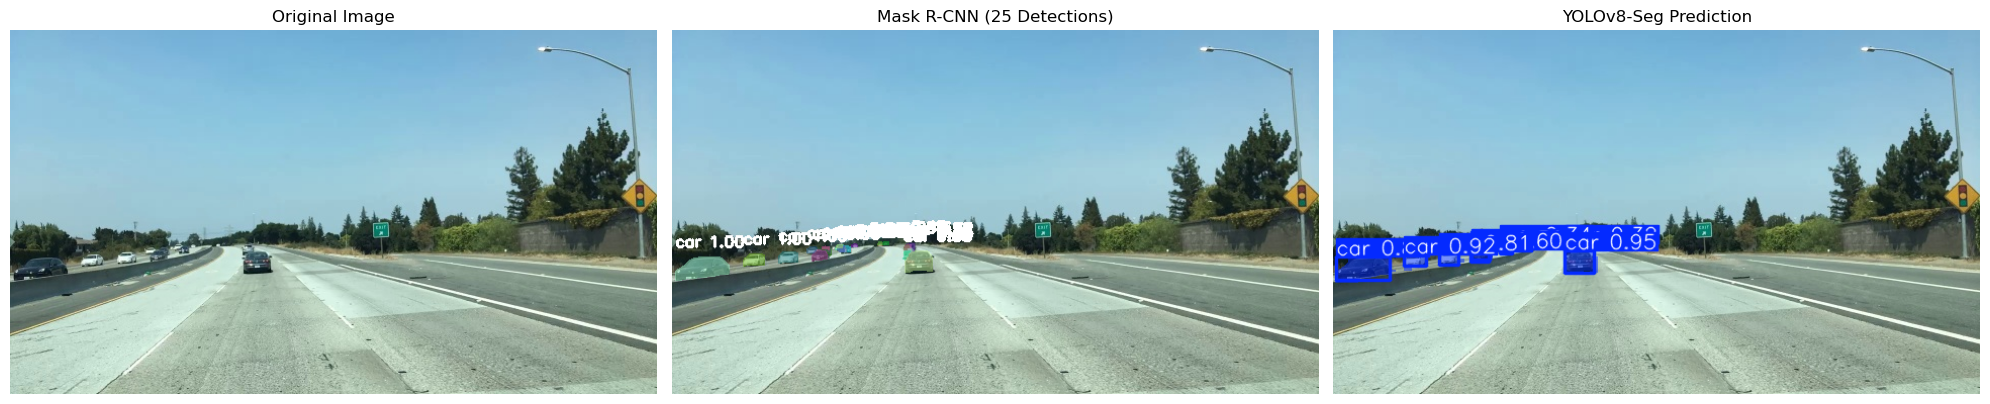

Loading YOLO from: C:\Users\Filip\runs/segment/Project3_Report\yolo_instance_run7\weights\best.pt

image 1/1 c:\Users\Filip\Desktop\Studia\sem5\CV\project3\datasets\bdd_yolo\images\val\80c62ee8-6713b97e.jpg: 384x640 18 cars, 5.1ms
Speed: 0.6ms preprocess, 5.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


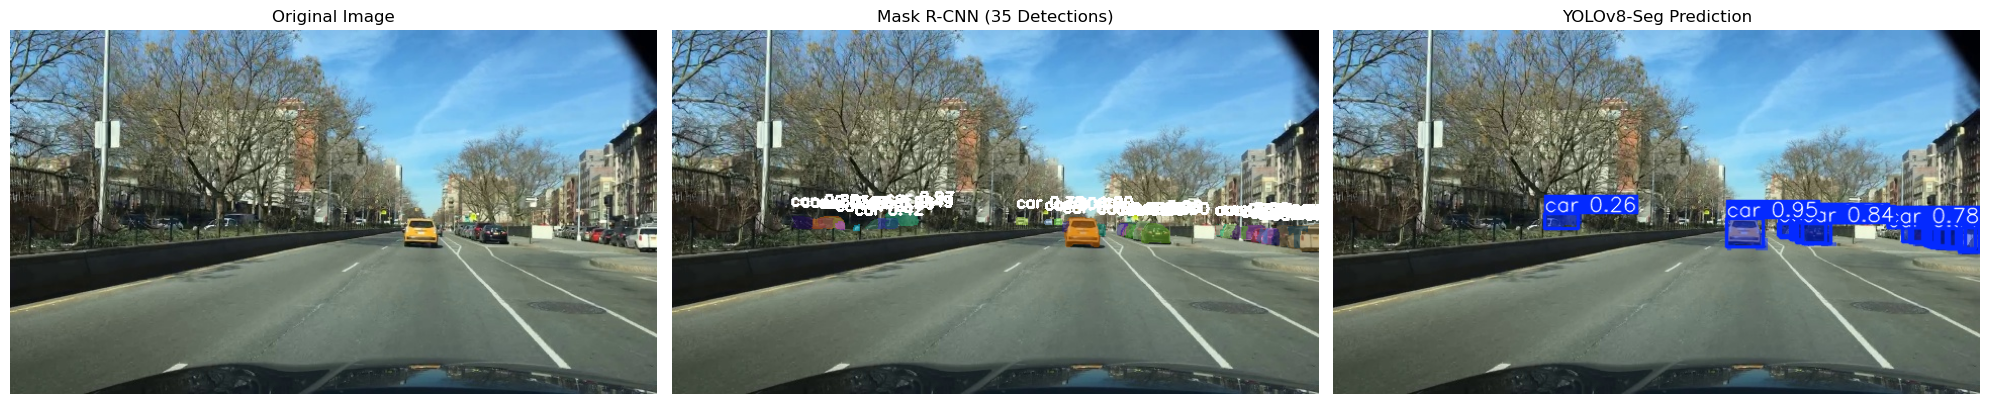

In [27]:

import sys
for i in range(4):
    def compare_predictions_final():
        dataset = BDDInstanceDataset('val')
        if len(dataset) == 0:
            print("Test dataset is empty.")
            return

        idx = random.randint(0, len(dataset)-1)
        
        img_tensor, _ = dataset[idx]
        img_path = os.path.join(dataset.img_dir, dataset.img_names[idx])
        
        ID_TO_NAME = {v+1: k for k, v in CLASS_MAP.items()}

        model_rcnn = get_model_instance_segmentation(len(CLASS_MAP)+1).to(DEVICE)
        if os.path.exists("mask_rcnn_bdd.pth"):
            model_rcnn.load_state_dict(torch.load("mask_rcnn_bdd.pth"))
        model_rcnn.eval()
        
        with torch.no_grad():
            out = model_rcnn([img_tensor.to(DEVICE)])[0]
            
        img_disp = img_tensor.permute(1, 2, 0).numpy()
        img_disp = (img_disp * 255).astype(np.uint8)
        img_disp = np.ascontiguousarray(img_disp) 
        
        overlay = img_disp.copy()
        detection_threshold = 0.3 
        num_detections = 0
        
        for i in range(len(out['scores'])):
            score = out['scores'][i].item()
            if score > detection_threshold:
                mask = out['masks'][i, 0].cpu().numpy()
                mask = (mask > 0.5).astype(np.uint8)
                box = out['boxes'][i].cpu().numpy().astype(int)
                label_id = out['labels'][i].item()
                label_name = ID_TO_NAME.get(label_id, "Unknown")
                
                color = np.random.randint(0, 255, (3,)).tolist()
                
                overlay[mask == 1] = overlay[mask == 1] * 0.5 + np.array(color) * 0.5
                
                x1, y1, x2, y2 = box
                label_text = f"{label_name} {score:.2f}"
                cv2.putText(overlay, label_text, (x1, y1 - 10), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
                num_detections += 1

        final_rcnn = cv2.addWeighted(overlay, 1.0, img_disp, 0.0, 0)

        possible_paths = [
            "Project3_Report/yolo_instance_run*",
            "runs/segment/Project3_Report/yolo_instance_run*",
            os.path.join(os.path.expanduser("~"), "runs/segment/Project3_Report/yolo_instance_run*")
        ]
        
        runs = []
        for p in possible_paths:
            runs.extend(glob.glob(p))
        
        if runs:
            latest_run = max(runs, key=os.path.getmtime)
            weights_path = os.path.join(latest_run, "weights", "best.pt")
            
            if os.path.exists(weights_path):
                print(f"Loading YOLO from: {weights_path}")
                model_yolo = YOLO(weights_path)
                res_yolo = model_yolo(img_path)
                yolo_plot = res_yolo[0].plot()
            else:
                print("YOLO weights not found.")
                yolo_plot = np.zeros((*IMG_SIZE[::-1], 3), dtype=np.uint8)
        else:
            print("No YOLO run found.")
            yolo_plot = np.zeros((*IMG_SIZE[::-1], 3), dtype=np.uint8)

        fig, ax = plt.subplots(1, 3, figsize=(20, 8))
    
        ax[0].imshow(img_disp)
        ax[0].set_title("Original Image")
        ax[0].axis('off')
        
        ax[1].imshow(final_rcnn)
        ax[1].set_title(f"Mask R-CNN ({num_detections} Detections)")
        ax[1].axis('off')
        
        ax[2].imshow(cv2.cvtColor(yolo_plot, cv2.COLOR_BGR2RGB))
        ax[2].set_title("YOLOv8-Seg Prediction")
        ax[2].axis('off')
        
        plt.tight_layout()
        plt.show()

    compare_predictions_final()

Loading YOLO from: C:\Users\Filip\runs/segment/Project3_Report\yolo_instance_run7\weights\best.pt

image 1/1 c:\Users\Filip\Desktop\Studia\sem5\CV\project3\datasets\bdd_yolo\images\val\80c62ee8-6713b97e.jpg: 384x640 18 cars, 5.4ms
Speed: 0.6ms preprocess, 5.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


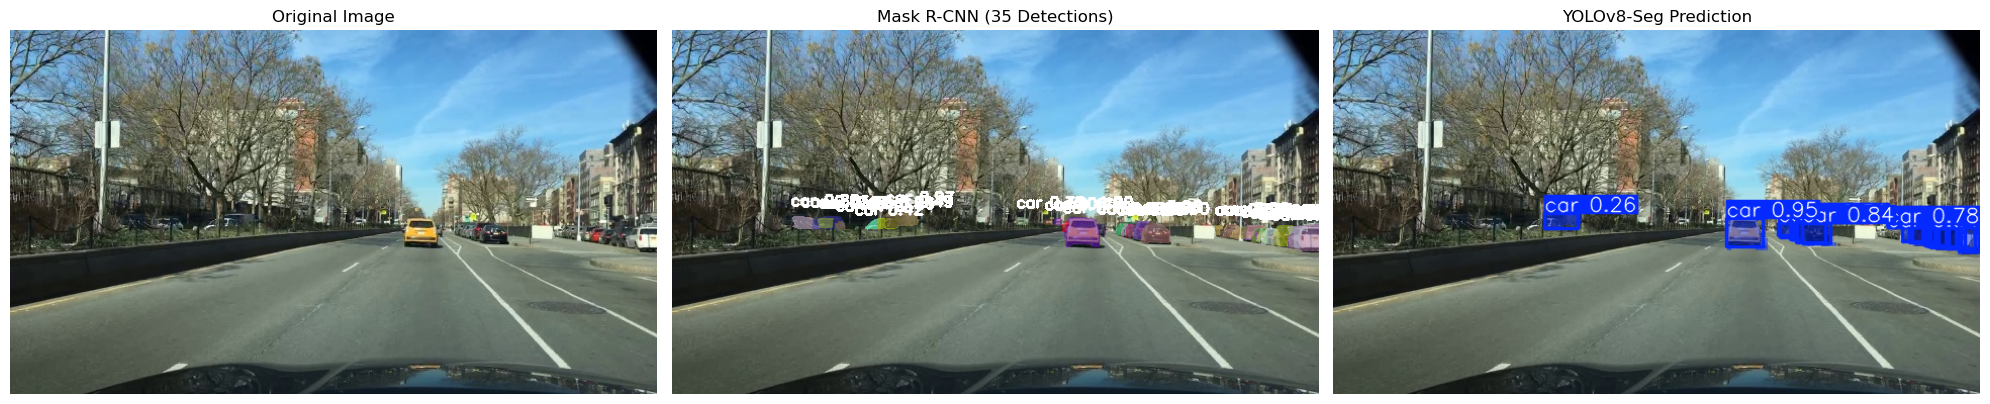

Loading YOLO from: C:\Users\Filip\runs/segment/Project3_Report\yolo_instance_run7\weights\best.pt

image 1/1 c:\Users\Filip\Desktop\Studia\sem5\CV\project3\datasets\bdd_yolo\images\val\8f6c02ef-d3ef7df6.jpg: 384x640 (no detections), 4.8ms
Speed: 0.6ms preprocess, 4.8ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)


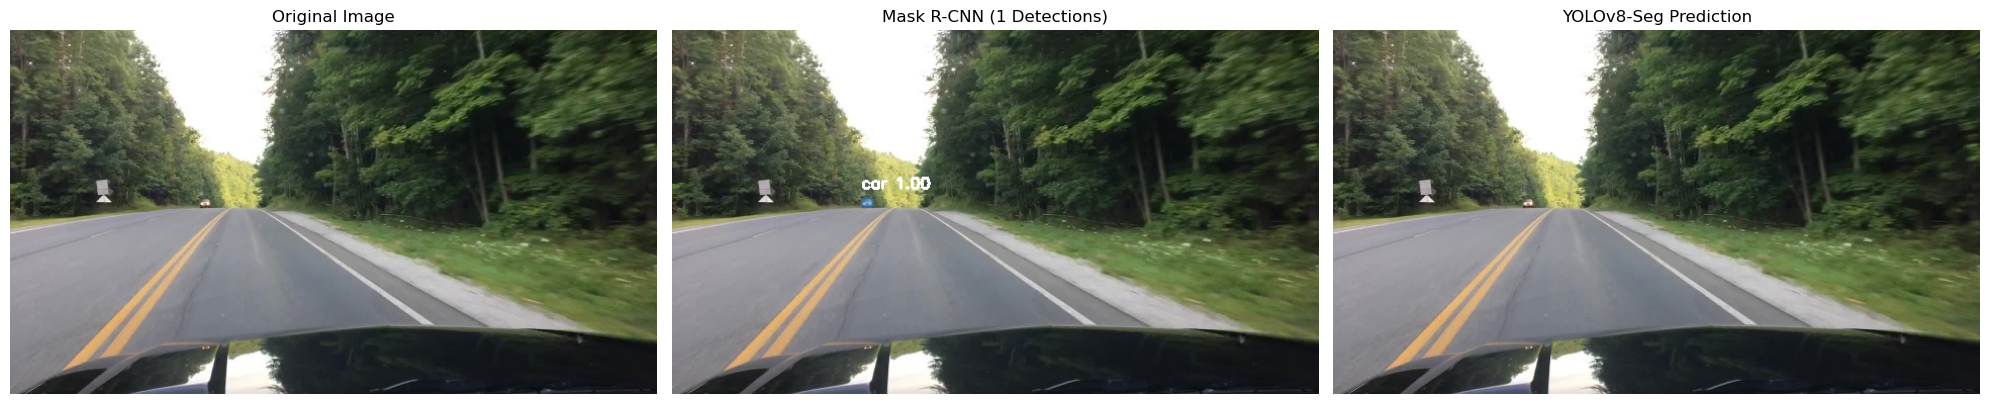

Loading YOLO from: C:\Users\Filip\runs/segment/Project3_Report\yolo_instance_run7\weights\best.pt

image 1/1 c:\Users\Filip\Desktop\Studia\sem5\CV\project3\datasets\bdd_yolo\images\val\8d80b4c8-d251240e.jpg: 384x640 8 cars, 5.3ms
Speed: 0.6ms preprocess, 5.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


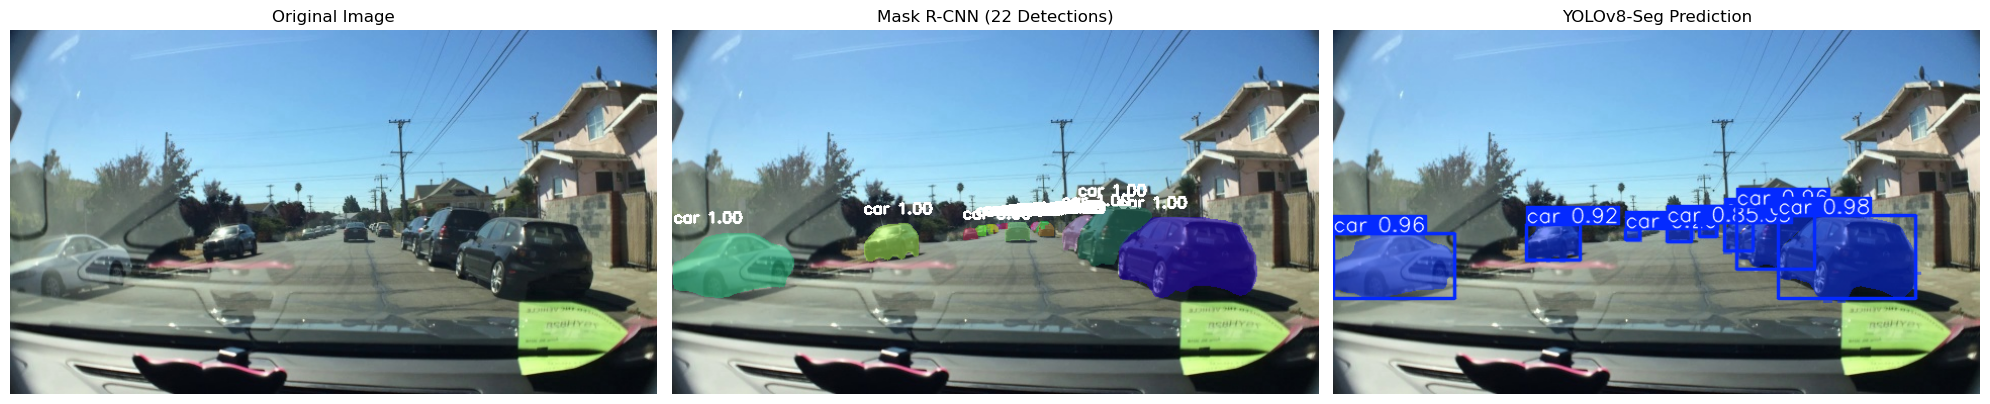

Loading YOLO from: C:\Users\Filip\runs/segment/Project3_Report\yolo_instance_run7\weights\best.pt

image 1/1 c:\Users\Filip\Desktop\Studia\sem5\CV\project3\datasets\bdd_yolo\images\val\865f0b43-ff7a6169.jpg: 384x640 6 cars, 5.4ms
Speed: 0.6ms preprocess, 5.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


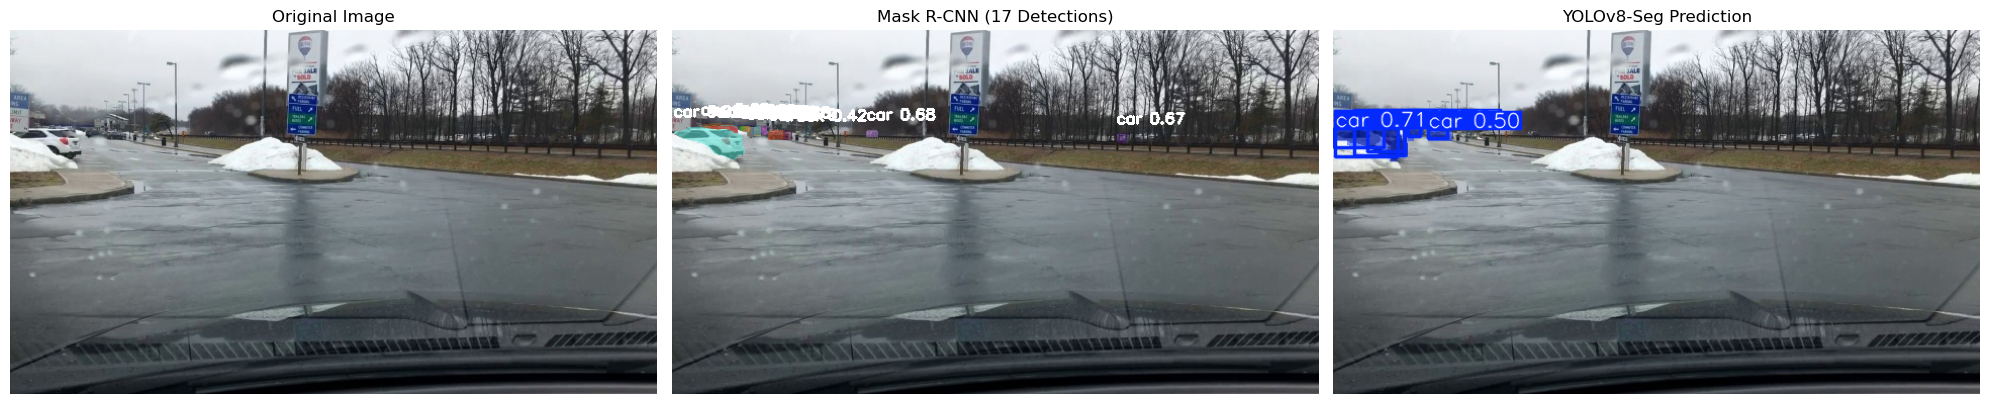

Loading YOLO from: C:\Users\Filip\runs/segment/Project3_Report\yolo_instance_run7\weights\best.pt

image 1/1 c:\Users\Filip\Desktop\Studia\sem5\CV\project3\datasets\bdd_yolo\images\val\932a0bc8-753b2c12.jpg: 384x640 19 cars, 5.6ms
Speed: 0.6ms preprocess, 5.6ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


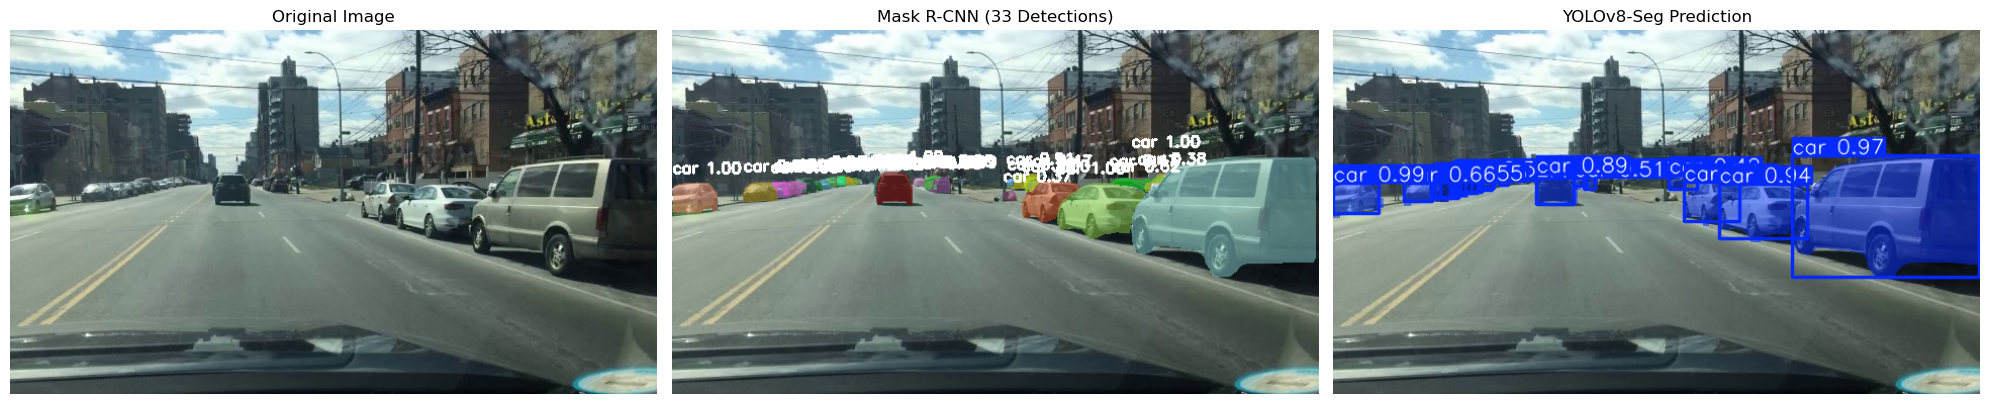

Loading YOLO from: C:\Users\Filip\runs/segment/Project3_Report\yolo_instance_run7\weights\best.pt

image 1/1 c:\Users\Filip\Desktop\Studia\sem5\CV\project3\datasets\bdd_yolo\images\val\91368b32-dd559718.jpg: 384x640 16 cars, 2 pedestrians, 4.5ms
Speed: 0.5ms preprocess, 4.5ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


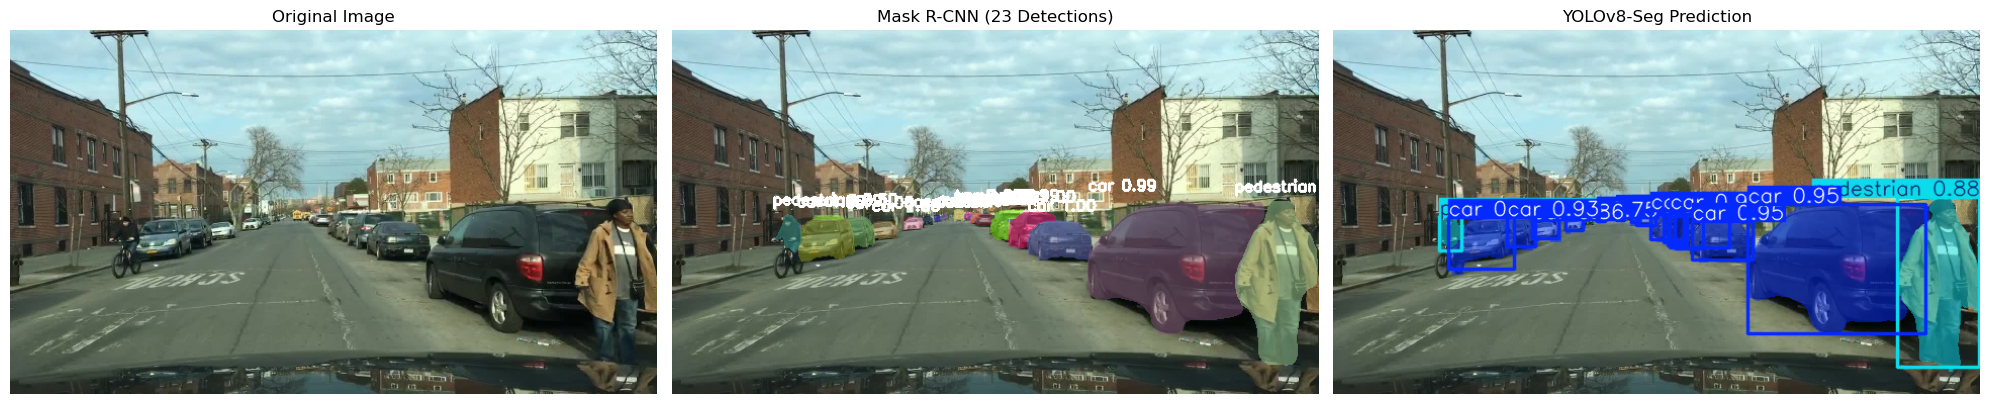

Loading YOLO from: C:\Users\Filip\runs/segment/Project3_Report\yolo_instance_run7\weights\best.pt

image 1/1 c:\Users\Filip\Desktop\Studia\sem5\CV\project3\datasets\bdd_yolo\images\val\8bcaa433-00000000.jpg: 384x640 6 cars, 5.1ms
Speed: 0.6ms preprocess, 5.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


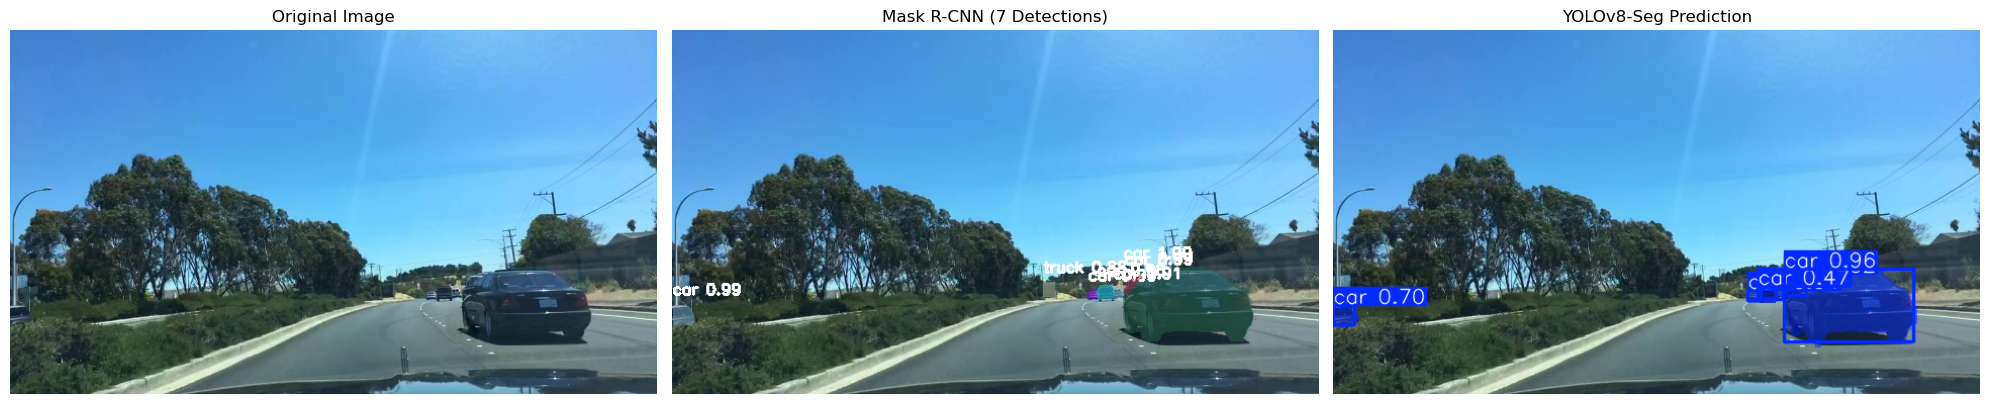

Loading YOLO from: C:\Users\Filip\runs/segment/Project3_Report\yolo_instance_run7\weights\best.pt

image 1/1 c:\Users\Filip\Desktop\Studia\sem5\CV\project3\datasets\bdd_yolo\images\val\88f82b2a-93448a4d.jpg: 384x640 16 cars, 5.0ms
Speed: 0.6ms preprocess, 5.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


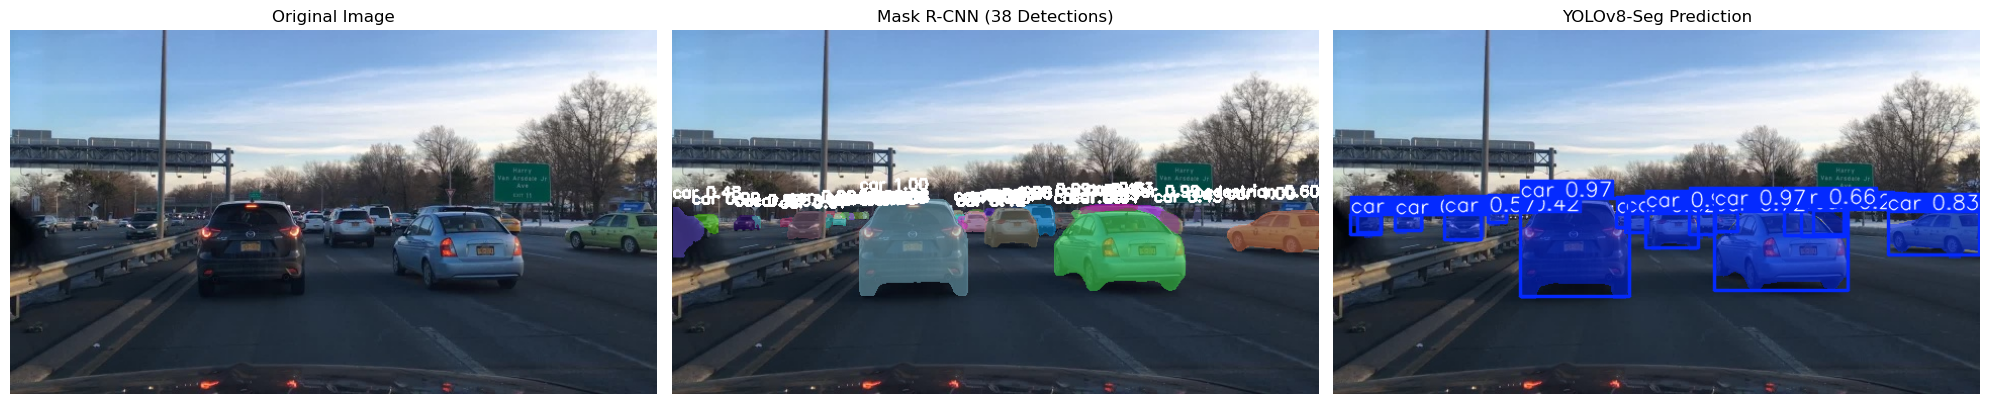

Loading YOLO from: C:\Users\Filip\runs/segment/Project3_Report\yolo_instance_run7\weights\best.pt

image 1/1 c:\Users\Filip\Desktop\Studia\sem5\CV\project3\datasets\bdd_yolo\images\val\86d7177b-5172a1bf.jpg: 384x640 12 cars, 5.2ms
Speed: 0.6ms preprocess, 5.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


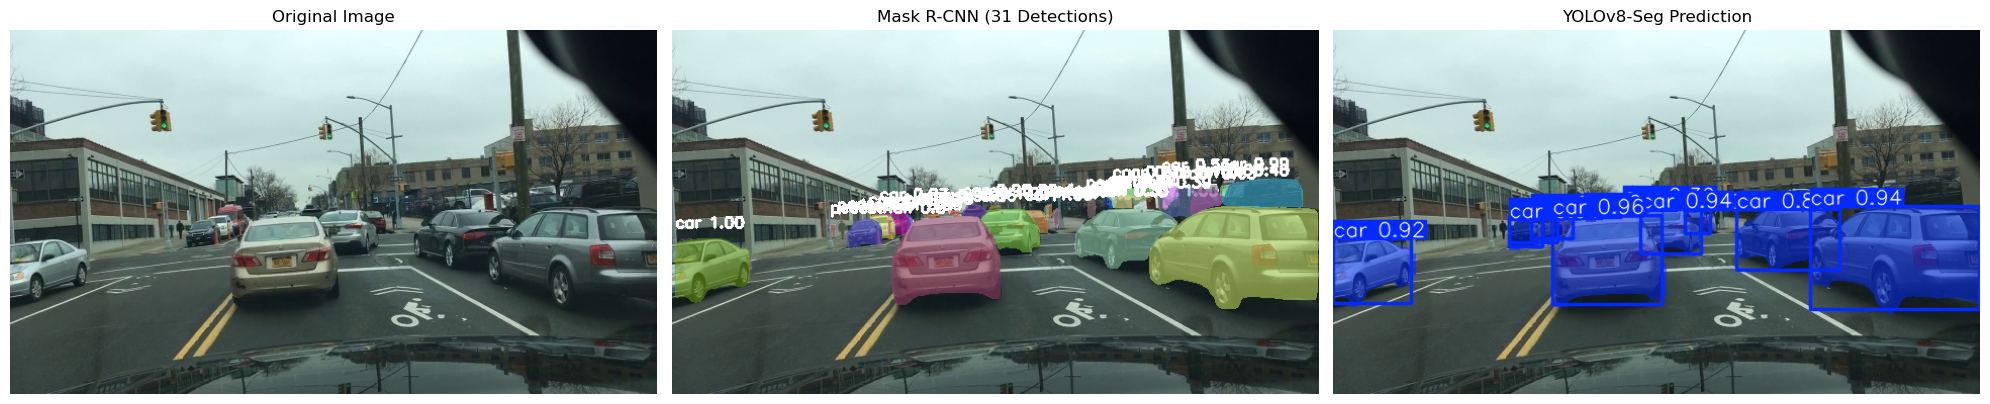

Loading YOLO from: C:\Users\Filip\runs/segment/Project3_Report\yolo_instance_run7\weights\best.pt

image 1/1 c:\Users\Filip\Desktop\Studia\sem5\CV\project3\datasets\bdd_yolo\images\val\8dc8faf3-50776226.jpg: 384x640 7 cars, 5 pedestrians, 4.5ms
Speed: 0.5ms preprocess, 4.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


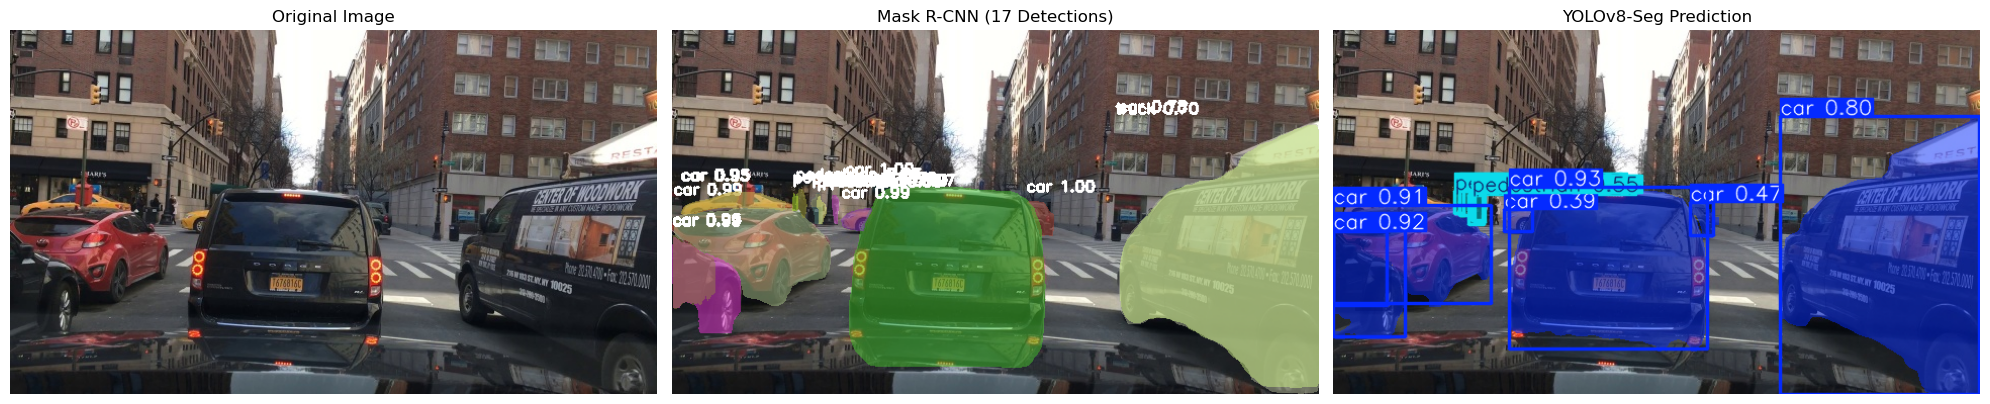

In [28]:

def compare_predictions_final(target_classes=None):
    dataset = BDDInstanceDataset('val')
    if len(dataset) == 0:
        print("Test dataset is empty.")
        return

    matching_indices = []
    for idx, img_name in enumerate(dataset.img_names):
        label_path = os.path.join(dataset.label_dir, img_name.replace('.jpg', '.txt'))
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                lines = f.readlines()
            for line in lines:
                cls_id = int(line.strip().split()[0])
                if target_classes is None or (cls_id+1) in target_classes:
                    matching_indices.append(idx)
                    break

    if not matching_indices:
        print("No images found with the specified classes.")
        return

    idx = random.choice(matching_indices)

    img_tensor, _ = dataset[idx]
    img_path = os.path.join(dataset.img_dir, dataset.img_names[idx])

    idx = random.randint(0, len(dataset)-1)
    
    img_tensor, _ = dataset[idx]
    img_path = os.path.join(dataset.img_dir, dataset.img_names[idx])
    
    ID_TO_NAME = {v+1: k for k, v in CLASS_MAP.items()}

    model_rcnn = get_model_instance_segmentation(len(CLASS_MAP)+1).to(DEVICE)
    if os.path.exists("mask_rcnn_bdd.pth"):
        model_rcnn.load_state_dict(torch.load("mask_rcnn_bdd.pth"))
    model_rcnn.eval()
    
    with torch.no_grad():
        out = model_rcnn([img_tensor.to(DEVICE)])[0]
        
    img_disp = img_tensor.permute(1, 2, 0).numpy()
    img_disp = (img_disp * 255).astype(np.uint8)
    img_disp = np.ascontiguousarray(img_disp) 
    
    overlay = img_disp.copy()
    detection_threshold = 0.3 
    num_detections = 0
    
    for i in range(len(out['scores'])):
        score = out['scores'][i].item()
        if score > detection_threshold:
            mask = out['masks'][i, 0].cpu().numpy()
            mask = (mask > 0.5).astype(np.uint8)
            box = out['boxes'][i].cpu().numpy().astype(int)
            label_id = out['labels'][i].item()
            label_name = ID_TO_NAME.get(label_id, "Unknown")
            
            color = np.random.randint(0, 255, (3,)).tolist()
            
            overlay[mask == 1] = overlay[mask == 1] * 0.5 + np.array(color) * 0.5
            
            x1, y1, x2, y2 = box
            label_text = f"{label_name} {score:.2f}"
            cv2.putText(overlay, label_text, (x1, y1 - 10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
            num_detections += 1

    final_rcnn = cv2.addWeighted(overlay, 1.0, img_disp, 0.0, 0)

    possible_paths = [
        "Project3_Report/yolo_instance_run*",
        "runs/segment/Project3_Report/yolo_instance_run*",
        os.path.join(os.path.expanduser("~"), "runs/segment/Project3_Report/yolo_instance_run*")
    ]
    
    runs = []
    for p in possible_paths:
        runs.extend(glob.glob(p))
    
    if runs:
        latest_run = max(runs, key=os.path.getmtime)
        weights_path = os.path.join(latest_run, "weights", "best.pt")
        
        if os.path.exists(weights_path):
            print(f"Loading YOLO from: {weights_path}")
            model_yolo = YOLO(weights_path)
            res_yolo = model_yolo(img_path)
            yolo_plot = res_yolo[0].plot()
        else:
            print("YOLO weights not found.")
            yolo_plot = np.zeros((*IMG_SIZE[::-1], 3), dtype=np.uint8)
    else:
        print("No YOLO run found.")
        yolo_plot = np.zeros((*IMG_SIZE[::-1], 3), dtype=np.uint8)

    fig, ax = plt.subplots(1, 3, figsize=(20, 8))
    
    ax[0].imshow(img_disp)
    ax[0].set_title("Original Image")
    ax[0].axis('off')
    
    ax[1].imshow(final_rcnn)
    ax[1].set_title(f"Mask R-CNN ({num_detections} Detections)")
    ax[1].axis('off')
    
    ax[2].imshow(cv2.cvtColor(yolo_plot, cv2.COLOR_BGR2RGB))
    ax[2].set_title("YOLOv8-Seg Prediction")
    ax[2].axis('off')
    
    plt.tight_layout()
    plt.show()

for i in range(10):
    compare_predictions_final(target_classes=[2])

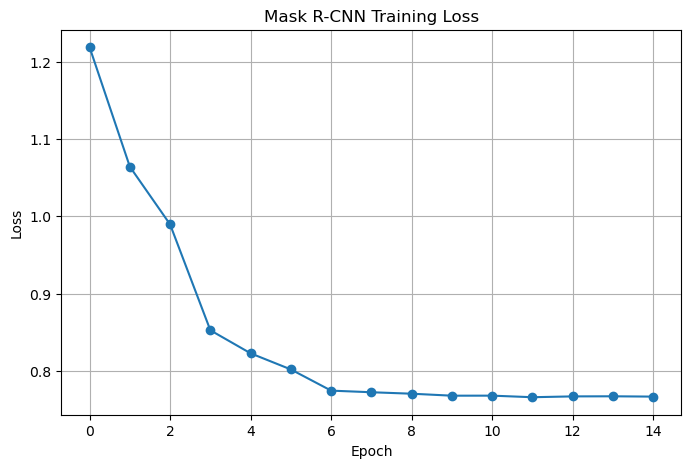

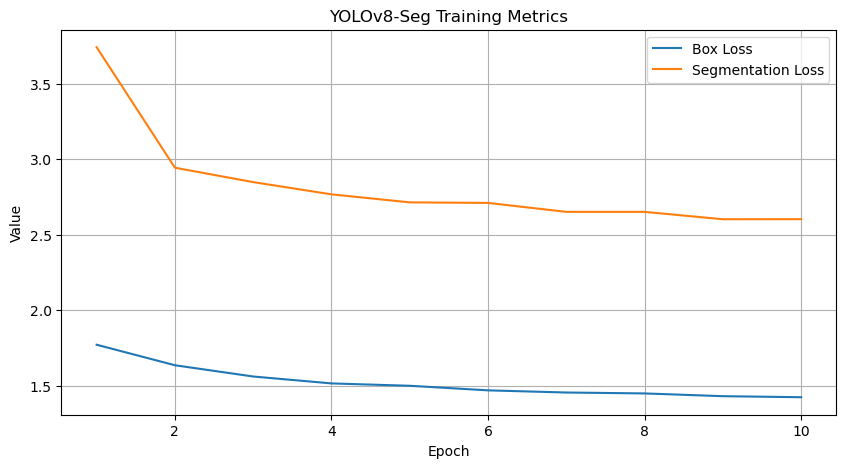

In [32]:
# --- Plot Mask R-CNN Training Loss from TensorBoard logs ---
import os
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing import event_accumulator

def plot_tensorboard_loss(logdir, tag='Loss/train', title='Mask R-CNN Training Loss'):
    ea = event_accumulator.EventAccumulator(logdir)
    ea.Reload()
    if tag not in ea.Tags()['scalars']:
        print(f"Tag '{tag}' not found in {logdir}")
        return
    events = ea.Scalars(tag)
    steps = [e.step for e in events]
    values = [e.value for e in events]
    plt.figure(figsize=(8,5))
    plt.plot(steps, values, marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(title)
    plt.grid(True)
    plt.show()

# Find the latest mask_rcnn run
def get_latest_maskrcnn_log():
    runs_dir = 'runs/mask_rcnn'
    if not os.path.exists(runs_dir):
        print('No mask_rcnn runs found.')
        return None
    files = [os.path.join(runs_dir, f) for f in os.listdir(runs_dir) if f.startswith('events.out')]
    if not files:
        print('No TensorBoard event files found for mask_rcnn.')
        return None
    return max(files, key=os.path.getmtime)

maskrcnn_log = get_latest_maskrcnn_log()
if maskrcnn_log:
    plot_tensorboard_loss(os.path.dirname(maskrcnn_log))

# --- Plot YOLOv8 Training Results from CSV ---
import pandas as pd

def plot_yolo_results(csv_path, title_prefix='YOLOv8-Seg'):
    df = pd.read_csv(csv_path)
    plt.figure(figsize=(10,5))
    if 'train/box_loss' in df.columns:
        plt.plot(df['epoch'], df['train/box_loss'], label='Box Loss')
    if 'train/seg_loss' in df.columns:
        plt.plot(df['epoch'], df['train/seg_loss'], label='Segmentation Loss')
    if 'metrics/mAP_0.5' in df.columns:
        plt.plot(df['epoch'], df['metrics/mAP_0.5'], label='mAP@0.5')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.title(f'{title_prefix} Training Metrics')
    plt.legend()
    plt.grid(True)
    plt.show()

# Find the latest YOLO run CSV
def get_latest_yolo_csv():
    report_dir = 'Project3_Report'
    csvs = []
    for subdir in os.listdir(report_dir):
        path = os.path.join(report_dir, subdir, 'results.csv')
        if os.path.exists(path):
            csvs.append(path)
    if not csvs:
        print('No YOLO results.csv found.')
        return None
    return max(csvs, key=os.path.getmtime)

yolo_csv = get_latest_yolo_csv()
if yolo_csv:
    plot_yolo_results(yolo_csv)

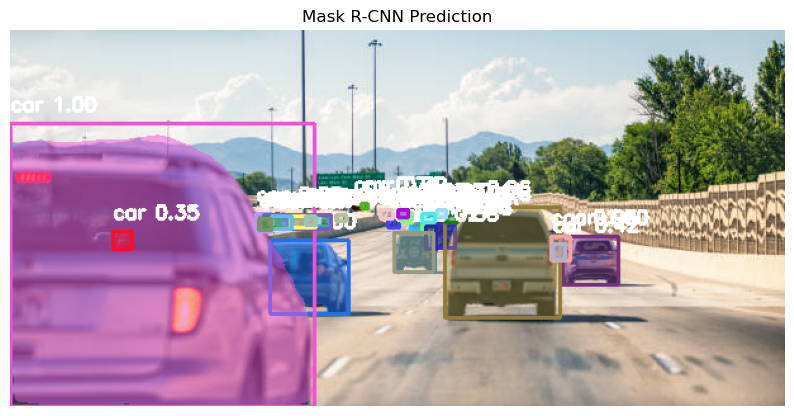

In [64]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt

def predict_maskrcnn_on_image(image_path, model_weights="mask_rcnn_bdd.pth", class_map=None, device=None, show=True):
    """
    Runs Mask R-CNN prediction on a single image.
    Args:
        image_path (str): Path to your image.
        model_weights (str): Path to the trained model weights.
        class_map (dict): Mapping from class names to indices (e.g., {'car': 0, ...}).
        device (str): 'cuda' or 'cpu'. If None, auto-detect.
        show (bool): Whether to display the result.
    Returns:
        result (dict): Contains boxes, masks, labels, and scores.
    """
    if class_map is None:
        class_map = {'car': 0, 'pedestrian': 1, 'truck': 2}
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Load image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_tensor = torch.from_numpy(img_rgb).permute(2, 0, 1).float() / 255.0
    img_tensor = img_tensor.to(device).unsqueeze(0)

    # Load model
    num_classes = len(class_map) + 1
    model = get_model_instance_segmentation(num_classes).to(device)
    model.load_state_dict(torch.load(model_weights, map_location=device))
    model.eval()

    # Predict
    with torch.no_grad():
        output = model(img_tensor)[0]

    # Visualization
    if show:
        img_disp = img_rgb.copy()
        ID_TO_NAME = {v+1: k for k, v in class_map.items()}
        for i in range(len(output['scores'])):
            score = output['scores'][i].item()
            if score > 0.3:
                mask = output['masks'][i, 0].cpu().numpy()
                mask = (mask > 0.5).astype(np.uint8)
                box = output['boxes'][i].cpu().numpy().astype(int)
                label_id = output['labels'][i].item()
                label_name = ID_TO_NAME.get(label_id, "Unknown")
                color = np.random.randint(0, 255, (3,)).tolist()
                img_disp[mask == 1] = img_disp[mask == 1] * 0.5 + np.array(color) * 0.5
                x1, y1, x2, y2 = box
                cv2.putText(img_disp, f"{label_name} {score:.2f}", (x1, y1 - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
                cv2.rectangle(img_disp, (x1, y1), (x2, y2), color, 2)
        plt.figure(figsize=(10, 6))
        plt.imshow(img_disp)
        plt.axis('off')
        plt.title("Mask R-CNN Prediction")
        plt.show()

    # Return results
    return {
        "boxes": output['boxes'].cpu().numpy(),
        "masks": output['masks'].cpu().numpy(),
        "labels": output['labels'].cpu().numpy(),
        "scores": output['scores'].cpu().numpy()
    }

# Example usage:
result = predict_maskrcnn_on_image("C:/Users/Filip/Desktop/Studia/sem5/CV/project3/image.jpg")